# N-Step DQN

# Conceito
Em algoritmos de Monte Carlo, o nosso modelo ¨aprende¨ em cada transição com base em **toda** a sequência de recompensas em um episódio, ou seja, o retorno completo ($G_{t}$). Já em one-step Temporal Diference, o aprendizado é feito observando apenas uma recompensa no futuro ($R_{t + 1}$) e aproximamos o restante do retorno ($G_{t+1}$) como sendo o valor do próximo estado ($V(S_{t + 1})$).


Agora, em N-step, tomamos uma abordagem intermediária a esses dois algoritmos. Não chegamos a utilizar a totalidade do retorno ($G_{t}$), mas **n** passos a frente do presente (**t**). Dessa forma, obtemos a seguinte expressão:

$$ G_t = R_{t+1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^{T -t -1} R_{T} $$


$$ G_{t:t + n} = R_{t+1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^{n -1} R_{t + n} + \gamma^n V_{t +n -1}(S_{t + n}) $$



onde $G_t$ representa o retorno completo (usado em Monte Carlo) e $G_{t:t + n}$ a aproximação do retorno com n-step, utilizando bootstraping do Valor do estado no instante t + n ($V_{t +n -1}(S_{t + n})$).

![N-Step](https://media.discordapp.net/attachments/688564171973197869/752614671974006844/unknown.png)

Vale notar que, no início do episódio, o agente não possui todas as experiências necessárias para fazer a estimativa do retorno. Para contornar isso, fazemos mudanças no replay buffer (explicadas mais a frente) para possibilitar o cálculo.

## Sarsa para $n$-Step
Agora que temos uma noção de como o $n$-step funciona, podemos nos preocupar em como nosso agente pode fazer uma escolha se baseando nesse processo. Para isso, mudamos nossa previsão para que ela preveja ações e não estados. Com esse objetivo, chegamos às seguintes expressões:

$$G_{t:t + n} = R_{t+1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^{n -1} R_{t + n} + \gamma^n Q_{t +n -1}(S_{t + n}, A_{t + n}) $$

$$Q_{t +n}(S_{t}, A_{t}) = Q_{t +n -1}(S_{t}, A_{t}) + \alpha [G_{t:t + n} - Q_{t +n -1}(S_{t}, A_{t})]$$


Tendo esse algoritmo, só precisamos de uma política $\pi$, por exemplo, $\varepsilon$-greedy.

## *Off-policy* $n$-step
Na implementação Off-Policy de n-Step, nosso objetivo é usar as informações obtidas a partir da nossa política atual para obter uma política ótima, da mesma forma como acontecia com o Q-Learning. Para obter a equação do Q-Learning, referente ao 1-step, bastou substituir o Q que dependia da ação escolhida pela nossa política, $Q(S_{t + 1}, A_{t + 1})$, por $max_{a'}Q(S_{t + 1}, a')$, referente à política ótima:

$$G_{t} = R_{t+1} + \gamma Q(S_{t + 1}, A_{t + 1})$$
$$G_{t} = R_{t+1} + \gamma max_{a'} Q(S_{t + 1}, a')$$

Entretanto, na equação de n-Step Sarsa, os termos $R_{t+i}$ também são dependentes da política que estamos seguindo, com exceção do $R_{t+1}$, que depende somente da ação tomada no tempo _t_. Basicamente, isso significa que, seguindo a política ótima, obteríamos  recompensas diferentes $R_{t+i}$, já que tomamos ações diferentes ao longo da trajetória.

$$G_{t:t + n} = R_{t+1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^{n -1} R_{t + n} + \gamma^n Q_{t +n -1}(S_{t + n}, A_{t + n})$$

Dessa forma, seria necessário implementar uma "correção" no nosso cálculo chamada *importance sampling*. Isso necessariamente requer que avaliemos a *importance sampling ratio* ($\rho_{t:t+n-1}$) para cada passo a frente (n) que queremos avaliar.

No entanto, com base nos artigos:
> "Rainbow: Combining Improvements in Deep Reinforcement Learning": https://arxiv.org/pdf/1710.02298.pdf

> "Understanding Multi-Step Deep Reinforcement
Learning: A Systematic Study of the DQN Target": https://arxiv.org/pdf/1901.07510.pdf

decidimos por não integrar *importance sampling* ao modelo pois, para valores de $n$ pequenos comumente como $n=3$, não aparentam existir impactos significativos da falta desse recurso. Além disso, para valores de $n$ maiores, o treinamento seria mais demorado, sem benefícios claros.

Logo, a única alteração feita para off-policy em relação a on-policy $n$-step, é utilizar o $max_{a'} Q(S_{t+n}, a')$ ao invés do $Q(S_{t+n}, A_{t+n})$.
<br/>
<br/>

$$G_{t:t + n} = R_{t+1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \dots + \gamma^{n -1} R_{t + n} + \gamma^n max_{a'} Q_{t +n -1}(S_{t + n}, a') $$



## Importações

In [1]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## N-Step Buffer

Para implementar nosso algoritmo n-step, vamos modificar o ReplayBuffer para retornar o n-step reward ($R_{t:t+n}$) em vez da recompensa no instante seguinte ($R_{t+1}$). 

$$R_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{n-1}R_{t + n}$$

Também alteraremos o estado seguinte de $S_{t+1}$ para $S_{t+n}$.

In [3]:
import numpy as np

class NStepBuffer:
    """Experience Replay Buffer com n-step para DQNs."""
    def __init__(self, max_length, observation_space, gamma, n_step=3):
        """Cria um Replay Buffer.

        Parâmetros
        ----------
        max_length: int
            Tamanho máximo do Replay Buffer.
        observation_space: int
            Tamanho do espaço de observação.
        gamma: float
            Fator de desconto.
        n_step: int
            Timesteps considerados.
        """
        self.gamma, self.n_step, self.episode_step = gamma, n_step, 0
        self.index, self.size, self.max_length = 0, 0, max_length

        self.states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.actions = np.zeros((max_length), dtype=np.int32)
        self.n_step_return = np.zeros((max_length), dtype=np.float32)
        self.next_states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.dones = np.zeros((max_length), dtype=np.float32)

    def __len__(self):
        """Retorna o tamanho do buffer."""
        return self.size

    def update(self, state, action, reward, next_state, done):
        """Adiciona uma experiência ao Replay Buffer.

        Parâmetros
        ----------
        state: np.array
            Estado da transição.
        action: int
            Ação tomada.
        reward: float
            Recompensa recebida.
        state: np.array
            Estado seguinte.
        done: bool
            Flag indicando se o episódio acabou.
        """
        self.states[self.index] = state
        self.actions[self.index] = action
        self.dones[self.index] = done
        self.n_step_return[self.index] = 0
        
        # Soma o reward atual aos n instantes passados
        for n in range(self.n_step):
            if self.episode_step - n >= 0:
                self.n_step_return[(self.index - n) % self.max_length] += reward * self.gamma**n
        
        if done:
            self.episode_step = -1
            self.dones[self.index - self.n_step + 1:self.index] = done
        
        if self.episode_step - self.n_step + 1 >= 0:
            self.next_states[(self.index - self.n_step + 1) % self.max_length] = next_state
        
        self.episode_step += 1
        self.index = (self.index + 1) % self.max_length
        if self.size < self.max_length:
            self.size = self.index
            
    def sample(self, batch_size):
        """Retorna um batch de experiências.
        
        Parâmetros
        ----------
        batch_size: int
            Tamanho do batch de experiências.

        Retorna
        -------
        states: np.array
            Batch de estados.
        actions: np.array
            Batch de ações.
        n_step_return: np.array
            Batch de retornos.
        next_states: np.array
            Batch de estados seguintes.
        dones: np.array
            Batch de flags indicando se o episódio acabou.
        """
        # Escolhe índices aleatoriamente do Replay Buffer
        idxs = np.random.randint(0, self.size, size=batch_size)

        return (self.states[idxs], self.actions[idxs], self.n_step_return[idxs], self.next_states[idxs], self.dones[idxs])

## Rede Neural

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 64), 
            nn.ReLU(),
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, out_dim)
        )

    def forward(self, x):
        return self.layers(x)

## Agente DQN

In [5]:
class DQNAgent:
    """
    Uma classe que cria um agente DQN que utiliza NStepBuffer como memória
    """
    def __init__(self, 
                 observation_space, 
                 action_space, 
                 lr=7e-4, 
                 gamma=0.99,
                 max_memory=100000,
                 epsilon_init=0.5,
                 epsilon_decay=0.9995,
                 min_epsilon=0.01,
                 n_step=3):
        """
        Inicializa o agente com os parâmetros dados
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.n_step = n_step
        self.memory = NStepBuffer(max_memory, observation_space.shape[0], gamma, n_step)
        self.action_space = action_space

        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.dqn = Network(observation_space.shape[0], action_space.n).to(self.device)

        self.optimizer  = optim.Adam(self.dqn.parameters(), lr=lr)

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon, self.min_epsilon)

        if np.random.random() < self.epsilon:
            action = self.action_space.sample()
            return action

        with torch.no_grad():
            state = torch.FloatTensor(state).to(self.device)
            action = self.dqn.forward(state).argmax(dim=-1)
            action = action.cpu().numpy()

        return action

    def remember(self, state, action, reward, new_state, done):
        self.memory.update(state, action, reward, new_state, done)

    def train(self, batch_size=32, epochs=1):
        # Se temos menos experiências que o batch size
        # não começamos o treinamento
        if batch_size > self.memory.size:
            return
        
        for epoch in range(epochs):
            # Pegamos uma amostra das nossas experiências para treinamento
            (states, actions, rewards, next_states, dones) = self.memory.sample(batch_size)

            # Transformar nossas experiências em tensores
            states = torch.as_tensor(states).to(self.device)
            actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
            rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
            next_states = torch.as_tensor(next_states).to(self.device)
            dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)

            q = self.dqn.forward(states).gather(-1, actions.long())

            with torch.no_grad():
                q2 = self.dqn.forward(next_states).max(dim=-1, keepdim=True)[0]

                target = (rewards + (1 - dones) * (self.gamma ** self.n_step) * q2).to(self.device)

            loss = F.mse_loss(q, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

### Definição de parâmetros

In [6]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [7]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_INIT = 0.7
EPS_END = 0.05
EPS_DECAY = 0.999
MAX_MEMORY = 100000
OBS_SPACE = env.observation_space
ACT_SPACE = env.action_space
N_STEP = 3

### Criando a DQN

In [8]:
agent = DQNAgent(observation_space=OBS_SPACE, 
                 action_space=ACT_SPACE, 
                 lr=7e-4, 
                 gamma=GAMMA, 
                 max_memory=MAX_MEMORY,
                 epsilon_init=EPS_INIT,
                 epsilon_decay=EPS_DECAY,
                 min_epsilon=EPS_END,
                 n_step=N_STEP)

## Treinamento

In [9]:
import math
from collections import deque

def train(agent, env, total_timesteps):
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []

    state = env.reset()
    timestep = 0
    episode = 0

    while timestep < total_timesteps:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        
        timestep += 1

        total_reward += reward


        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()

        if episode_returns:
            avg_returns.append(np.mean(episode_returns))

        total_reward *= 1 - done
        state = next_state

        ratio = math.ceil(100 * timestep / total_timesteps)

        avg_return = avg_returns[-1] if avg_returns else np.nan
        
        print(f"\r[{ratio:3d}%] timestep = {timestep}/{total_timesteps}, episode = {episode:3d}, avg_return = {avg_return:10.4f}", end="")

    return avg_returns

In [10]:
returns = train(agent, env, 40000)

[100%] timestep = 40000/40000, episode = 135, avg_return =   493.0000

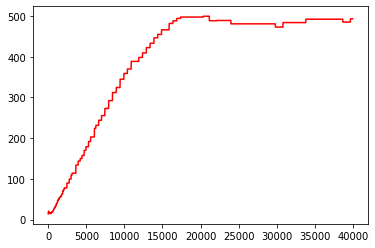

In [11]:
plt.plot(returns, 'r')
plt.show()

Comparando com a performance de uma DQN sem $n$-step:

![DQN](https://media.discordapp.net/attachments/688564171973197869/752599003962540094/unknown.png)

## Testando nosso Agente

In [12]:
import math

def evaluate(agent, env, episodes=10):
    total_reward = 0
    episode_returns = deque(maxlen=episodes)
    
    episode = 0

    state = env.reset()

    while episode < episodes:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)        
       
        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            episode += 1
            next_state = env.reset()

        total_reward *= 1 - done
        state = next_state

        ratio = math.ceil(100 * episode / episodes)
        
        print(f"\r[{ratio:3d}%] episode = {episode:3d}, avg_return = {np.mean(episode_returns):10.4f}", end="")

    return np.mean(episode_returns)

In [13]:
evaluate(agent, env, 10)

D:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[100%] episode =  10, avg_return =   471.1000

471.1

## Referências

"Reinforcement Learning: An Introduction"

"Rainbow: Combining Improvements in Deep Reinforcement Learning": https://arxiv.org/pdf/1710.02298.pdf

"Understanding Multi-Step Deep Reinforcement
Learning: A Systematic Study of the DQN Target": https://arxiv.org/pdf/1901.07510.pdf